In [1]:
using DataFrames
using Plots
pyplot()

INFO: Recompiling stale cache file C:\Users\holly\.julia\lib\v0.6\PyPlot.ji for module PyPlot.


Plots.PyPlotBackend()

# Description of DFM

## Static Form of the DFM
Equation (6) 
$$X_t=\Lambda F_t+e_t$$
Equation (7)
$$F_t=\Phi(L)F_{t-1}+G\eta_t$$

### Principal Components Normalization
Equation (11) in the paper
$$\frac{1}{N}\Lambda'\Lambda=I_r$$ and $\Sigma_F\equiv E\left[F_tF_t^\prime\right]$ diagonal.

#### Principal Components Estimation
Equation (13)
$$\min_{F_1,\dots,F_T,\Lambda}V_r(\Lambda,F)$$
where
$$V_r\left(\Lambda,F\right)=\frac{1}{NT}\sum_{t=1}^T\left(X_t-\Lambda F_t\right)'\left(X_t-\Lambda F_t\right)$$

# Figure 1
Figure 1 assumes there is only one factor which evoles as
$$f_t = \Psi_4f_{t-1=}+\dots+\Psi_4f_{t-4}.$$
All observed variables $y_t$ depend on the current value of $f$ and from first to fourth lags of $f$, and constant:
$$X_{it} = \lambda_i+\lambda_{i0}f_t+\lambda_{i1}f_{t1}+\dots+\lambda_{i4}f_{t4}.$$

In [2]:
nt_min = 20 # min number of obs for any series used to est factors

20

#### Useful functions

In [3]:
nanf(f::Function, x) = f(filter(!isnan, x))
nanmean(x) = nanf(mean, x)
nanstd(x) = nanf(std, x)
nansum(x) = nanf(sum, x)

nansum (generic function with 1 method)

In [4]:
apply_f_vertically(f::Function, df::DataFrame) =
    Matrix(map(f, eachcol(df)))
nanmean(df::DataFrame) = apply_f_vertically(nanmean, df)
nanstd(df::DataFrame) = apply_f_vertically(nanstd, df)
nansum(df::DataFrame) = apply_f_vertically(nansum, df)

nansum (generic function with 2 methods)

In [5]:
dropna_row(df::DataFrame) = df[complete_cases(df), :]

dropna_row (generic function with 1 method)

In [6]:
function dropna_row(A::Matrix)
    nanrows = any(isnan.(A), 2)
    return A[.!vec(nanrows), :]
end

dropna_row (generic function with 2 methods)

## Import data

In [7]:
data = readcsv("data/bpdata.csv")
header = data[1, :]
year = data[2:end, 1]
data = Float64.(data[2:end, 2:end])

224×86 Array{Float64,2}:
 NaN            NaN            NaN            …  12.3235     NaN          
   0.0142268      0.00530395     0.0228269        9.45272      0.0152701  
  -0.0116989      0.000417996    0.0050264       -4.38442      0.00203857 
  -0.00581949    -0.00882744    -0.0629256       -2.85467     -0.00647572 
   0.012316      -0.000459845    0.0175352       -0.758017     0.0188318  
  -0.0134915      0.00268641     0.0084729    …  -8.42778     -0.00129345 
  -0.00717594    -0.0139067     -0.0219165       -6.79728     -0.00454431 
  -0.0218157     -0.00861225    -0.0393015       -8.76649     -0.0154271  
  -0.00283434    -0.0101246     -0.0704661       -6.96877     -0.0272235  
   0.00883281     0.00493428     0.0066869        8.19584     -0.0158283  
   0.00697616    -0.00494625     0.0103326    …   8.36063     -0.00347905 
   0.0105292      0.0100276      0.0335589       11.6922       0.000487977
   0.00833999     0.000812098    0.00756745       3.22391      0.0073634  


## Restrict sample

In [8]:
initperiod = 3 # first two samples and header are dropped

# exclude year data
xdata = Float64.(data[initperiod:end, :])

222×86 Array{Float64,2}:
 -0.0116989     0.000417996   0.0050264    …  -4.38442      0.00203857 
 -0.00581949   -0.00882744   -0.0629256       -2.85467     -0.00647572 
  0.012316     -0.000459845   0.0175352       -0.758017     0.0188318  
 -0.0134915     0.00268641    0.0084729       -8.42778     -0.00129345 
 -0.00717594   -0.0139067    -0.0219165       -6.79728     -0.00454431 
 -0.0218157    -0.00861225   -0.0393015    …  -8.76649     -0.0154271  
 -0.00283434   -0.0101246    -0.0704661       -6.96877     -0.0272235  
  0.00883281    0.00493428    0.0066869        8.19584     -0.0158283  
  0.00697616   -0.00494625    0.0103326        8.36063     -0.00347905 
  0.0105292     0.0100276     0.0335589       11.6922       0.000487977
  0.00833999    0.000812098   0.00756745   …   3.22391      0.0073634  
  0.0012303     0.0024063     0.0127609       -2.711        0.00208582 
  1.74e-5      -0.0016512    -0.00655048      -4.1126       0.00443766 
  ⋮                                    

## Standardize data

In [9]:
xdata_df = DataFrame(xdata)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86
1,-0.0116989,0.000417996,0.0050264,0.00246625,-0.00326463,-0.0790124,-0.00147975,0.0152494,0.0118482,-0.024915,-0.00498891,0.00169134,0.00930034,-0.0202841,-0.00935316,0.0144959,-0.00573149,-0.0116777,-0.015238,-0.0152102,-0.0525197,0.00228093,0.000971413,-0.120124,-0.194273,-0.00975078,-0.0102119,-0.046722,0.00410129,0.00205324,NaN,-0.00610939,-0.00668619,-0.0104329,-0.00291447,-0.0112856,-0.0213455,0.00520428,-0.00943522,-0.00440014,-0.000743416,-0.00819408,-0.00570289,-0.00245758,-0.00394874,-0.0340392,-0.00120518,-0.00260217,0.000426697,0.0068248,-0.004025,-0.00662232,-0.000251359,-0.00320003,0.000580855,0.167021,0.404021,-0.156578,0.717014,0.281716,-0.133852,0.0582626,0.163721,0.0289703,-0.201499,NaN,NaN,NaN,NaN,0.0360857,-0.0124779,-0.00691635,-0.0533992,NaN,-0.0770044,-13.9848,-0.0252816,-0.00118184,-0.0989509,-0.0596414,-0.015713,0.00104151,2.50052,1.51749,-4.38442,0.00203857
2,-0.00581949,-0.00882744,-0.0629256,0.00114872,-0.000902454,0.0198127,-0.0236725,-0.0187833,-0.0173627,-0.0347269,-0.000507128,-0.0149292,-0.0137298,-0.00462032,-0.0154895,-0.043808,-0.0407816,-0.00313488,-0.0118466,-0.00827169,-0.00593753,-0.0221506,-0.0203229,0.0129465,0.0304035,-0.0231772,-0.0656206,-0.167345,-0.00367598,-0.0269791,NaN,-0.00246852,-0.00363068,-0.00394525,-0.0002516,-0.00597977,-0.00552602,-0.00165274,-0.0176718,0.00174036,-0.000402132,-0.00452372,-0.000653176,-0.00190623,0.00135556,0.000908343,-0.00259309,0.00419802,-0.00233556,-0.0011628,0.0111912,-0.00126177,0.00254587,-0.00398937,-3.11e-5,0.332866,0.303909,-0.0111704,0.18326,0.347291,0.198872,0.0633321,0.0471377,0.1077,-0.0155907,NaN,NaN,NaN,NaN,0.0594418,-0.00401506,-0.00382656,-0.3175,NaN,-0.176789,-15.217,-0.00819928,-0.0263144,0.00191831,-0.0167168,0.00366857,-0.0364612,0.088743,-6.33572,-2.85467,-0.00647572
3,0.012316,-0.000459845,0.0175352,-0.00193086,-0.00457743,0.0836151,0.0208606,0.017329,0.0195644,0.0242492,0.00758827,-0.0237988,-0.04217,0.0640172,0.00644621,0.101338,0.0221842,0.00158135,0.0188524,0.014404,0.0478876,0.0255475,0.0282044,0.0827874,0.13637,0.0148426,0.110026,0.287095,-0.00137879,0.0244213,NaN,0.00658649,0.00769614,0.0213344,0.00246661,0.0144694,0.0340982,0.00311673,-0.0200881,0.00181508,0.000463413,0.0112676,0.00491343,0.00378385,0.00179794,0.0123577,0.00216076,0.000770416,0.00357785,-0.00213772,0.0083604,-0.00794368,-0.00010133,-0.00040705,-0.467302,-0.467931,-0.418495,-0.0207706,-1.01713,-0.420443,-0.335051,-0.0918873,-0.128545,-0.0109528,-0.035159,NaN,NaN,NaN,NaN,-0.10168,-0.00582102,0.002195,-0.114883,NaN,0.156753,-15.1148,0.0160026,0.00738099,-0.0146345,-0.00380261,-0.070814,-0.051811,-19.9552,1.67848,-0.758017,0.0188318
4,-0.0134915,0.00268641,0.0084729,0.000181831,0.00380718,-0.109974,-0.0302803,-2.92e-5,-8.04e-6,-0.0913899,-0.00216077,0.0040144,-0.00177329,-0.0193272,0.0137121,0.0449954,-0.0075092,-0.00396232,-0.0220478,-0.0194146,-0.0325454,-0.0110202,-0.00459917,-0.0610088,-0.0933122,-0.0224446,-0.0288768,-0.0335815,0.00425439,-0.0204477,NaN,-0.00383928,-0.00461884,-0.0127354,-0.000178801,-0.00997505,-0.0201285,-0.0020271,0.00353996,-0.00175089,-0.000672862,-0.00622956,-0.00398063,0.00296937,-0.00183335,-0.00521506,0.00140513,0.000675359,0.00204922,-0.00279134,0.00452911,0.000650225,-0.00111869,0.00811094,0.632099,0.0979651,0.151858,-0.0586832,-0.250825,0.0451832,0.0643789,0.0844154,0.0129512,-0.0387032,-0.0863974,NaN,NaN,NaN,NaN,0.11523,0.00680841,-0.00221081,-0.41222,NaN,-0.409711,-18.0118,-0.0232244,0.0037975,-0.013849,-0.0237495,-0.0616635,0.0255509,-23.5312,-6.2066,-8.42778,-0.00129345
5,-0.00717594,-0.0139067,-0.0219165,-0.0120076,-0.0128964,-0.0146509,-0.0335632,-0.0607614,-0.0322223,-0.036276,-0.0005346

In [10]:
tmp = size(xdata, 1) - sum(isnan.(xdata), 1)
tmp = (tmp-1)./tmp

1×86 Array{Float64,2}:
 0.995495  0.995495  0.995495  0.995495  …  0.995495  0.995495  0.995475

In [11]:
xdatamean = nanmean(xdata_df)
xdatastd = nanstd(xdata_df).*sqrt.(tmp)

1×86 Array{Float64,2}:
 0.00826165  0.0066062  0.029738  …  9.74479  5.70165  7.25821  0.010707

In [12]:
data_standardized  = (xdata .- xdatamean)./xdatastd

222×86 Array{Float64,2}:
 -1.40748     0.0744596   0.173258    0.616121   …  -0.60472       0.196305 
 -0.695838   -1.32505    -2.11177     0.294728      -0.393958     -0.598907 
  1.4993     -0.0584219   0.593892   -0.456492      -0.105092      1.76475  
 -1.62447     0.417836    0.289153    0.0588688     -1.16179      -0.114897 
 -0.860024   -2.09391    -0.732752   -2.91457       -0.937152     -0.418518 
 -2.63204    -1.29248    -1.31736    -0.272196   …  -1.20846      -1.43494  
 -0.334512   -1.5214     -2.36533    -0.172815      -0.960779     -2.53669  
  1.07769     0.758103    0.229095    0.924045       1.12853      -1.47241  
  0.852962   -0.737543    0.35169    -1.85           1.15123      -0.319026 
  1.28303     1.5291      1.13272     1.66387        1.61024       0.0514838
  1.01804     0.134116    0.258706   -0.297892   …   0.443519      0.69363  
  0.157477    0.375434    0.433345    1.02332       -0.374164      0.200718 
  0.0106661  -0.238761   -0.216038   -0.488643     

### only use datas with inclcode==1 

In [13]:
inclcode = readcsv("data/inclcode.csv")

tmp = Matrix{Float64}(size(data_standardized, 1), count(inclcode.==1))
j = 0
for i = 1:size(xdata, 2)
    if inclcode[1, i] == 1
        j = j + 1
        tmp[:, j] = data_standardized[:, i]
    end
end
data_standardized = tmp

222×58 Array{Float64,2}:
  0.173258    0.616121   -0.449517    …  -0.60472       0.196305 
 -2.11177     0.294728   -0.119795       -0.393958     -0.598907 
  0.593892   -0.456492   -0.632765       -0.105092      1.76475  
  0.289153    0.0588688   0.537598       -1.16179      -0.114897 
 -0.732752   -2.91457    -1.79397        -0.937152     -0.418518 
 -1.31736    -0.272196   -0.875153    …  -1.20846      -1.43494  
 -2.36533    -0.172815   -0.148152       -0.960779     -2.53669  
  0.229095    0.924045    0.891152        1.12853      -1.47241  
  0.35169    -1.85       -0.861188        1.15123      -0.319026 
  1.13272     1.66387     0.919308        1.61024       0.0514838
  0.258706   -0.297892    0.191752    …   0.443519      0.69363  
  0.433345    1.02332    -0.40217        -0.374164      0.200718 
 -0.216038   -0.488643    0.124493       -0.567269      0.420373 
  ⋮                                   ⋱                          
  0.427577   -0.21763    -0.00601165  …   0.0423418

## Compute Total Sum of Squares

In [14]:
tss = sum(nansum(DataFrame(data_standardized.^2)))

12700.0

## Remove columns containing NaN

In [15]:
xbal = dropna_row(data_standardized')'

222×49 Array{Float64,2}:
  0.173258    0.616121   -0.449517    …   0.258725     -0.60472   
 -2.11177     0.294728   -0.119795       -1.11863      -0.393958  
  0.593892   -0.456492   -0.632765        0.286961     -0.105092  
  0.289153    0.0588688   0.537598       -1.09599      -1.16179   
 -0.732752   -2.91457    -1.79397        -1.68371      -0.937152  
 -1.31736    -0.272196   -0.875153    …  -1.74514      -1.20846   
 -2.36533    -0.172815   -0.148152       -2.01691      -0.960779  
  0.229095    0.924045    0.891152       -1.35314       1.12853   
  0.35169    -1.85       -0.861188        0.333847      1.15123   
  1.13272     1.66387     0.919308        0.997865      1.61024   
  0.258706   -0.297892    0.191752    …   1.45154       0.443519  
  0.433345    1.02332    -0.40217        -0.000547148  -0.374164  
 -0.216038   -0.488643    0.124493       -1.09005      -0.567269  
  ⋮                                   ⋱                           
  0.427577   -0.21763    -0.00601165 

# PCA

In [16]:
nt, ns = size(data_standardized)
nfac_o = 0 # number of observed factors
nfac_u = 1 # number of unobserved factors
nfac_t = nfac_o + nfac_u # total number of factors

1

In [17]:
U, S, V = svd(xbal)

f = (xbal*V)[:, 1:nfac_u]

fa = f

222×1 Array{Float64,2}:
  3.59133  
  3.81922  
 -4.8285   
  3.57713  
  7.32604  
  9.797    
  8.64339  
 -0.0988581
 -2.12375  
 -5.12746  
 -2.96291  
 -1.34933  
  1.74576  
  ⋮        
 -3.2693   
 -0.524436 
 -0.440566 
 -1.56502  
 -1.99228  
 -1.82968  
 -2.3149   
 -3.62214  
 -1.37052  
 -4.2118   
 -3.41265  
 -3.06683  

# Least square

In [18]:
function part1!(lambda, i, fa, xdata_stdi, nt_min)
    tmp = dropna_row([xdata_stdi fa])
    if size(data_standardized, 1) >= nt_min
        y = tmp[:, 1]
        x = tmp[:, 2:end]
        xx = x'*x
        bols = (xx)\(x'*y)
        b = bols
        lambda[i, :] = b'
    end
end

part1! (generic function with 1 method)

In [19]:
lambda = Matrix{Float64}(ns, nfac_t)
ssr = 0

0

In [20]:
diff = 1000
tol = 1e-8
while diff > tol*nt*ns
    ssr_old = ssr
    for i = 1:ns
        part1!(lambda, i, fa, data_standardized[:, i], nt_min)
    end

    edata = data_standardized
    for t = 1:nt
        tmp = dropna_row([edata[t, :] lambda[:, nfac_o+1:end]])
        y = tmp[:, 1]
        x = tmp[:, 2:end]
        b = x\y
        f[t, :] = b'
    end
    fa = f
    ehat = data_standardized - fa*lambda'
    ssr = sum(nansum(ehat.^2))
    diff = abs(ssr_old - ssr)
    @show diff
end

diff = 7805.186076916562
diff = 0.48167949559046974
diff = 0.002725418577028904


In [21]:
lambda = lambda.*xdatastd

58×86 Array{Float64,2}:
 -0.000891552  -0.000712904  …  -0.61529    -0.783265  -0.00115543 
 -0.000863262  -0.000690283     -0.595766   -0.758412  -0.00111877 
 -0.000803759  -0.000642703     -0.554701   -0.706135  -0.00104166 
 -0.00149731   -0.00119729      -1.03335    -1.31545   -0.00194049 
 -0.00152583   -0.00122009      -1.05303    -1.34051   -0.00197745 
 -0.0008399    -0.000671602  …  -0.579643   -0.737887  -0.00108849 
 -0.00110275   -0.000881781     -0.761043   -0.96881   -0.00142914 
  0.000194375   0.000155427      0.134145    0.170767   0.000251907
 -0.00114438   -0.000915072     -0.789776   -1.00539   -0.0014831  
 -0.000108678  -8.69012e-5      -0.0750023  -0.095478  -0.000140845
 -0.000536583  -0.000429063  …  -0.370314   -0.47141   -0.000695401
 -0.00104855   -0.000838443     -0.723639   -0.921194  -0.0013589  
 -0.00144762   -0.00115755      -0.999054   -1.2718    -0.00187609 
  ⋮                          ⋱                          ⋮          
 -0.00131386   -0.001050

diff = 4.325549798522843e-5


In [22]:
fac_est = fill(NaN, size(data, 1), nfac_t)
fac_est[initperiod:end,  :] = fa
fac_est

224×1 Array{Float64,2}:
 NaN        
 NaN        
   3.55906  
   3.97141  
  -5.29767  
   3.52022  
   7.35006  
   9.7971   
   8.80436  
   0.0734791
  -2.08731  
  -5.13417  
  -2.95774  
   ⋮        
  -3.28253  
  -0.435026 
  -0.489242 
  -1.55541  
  -2.36165  
  -2.07796  
  -1.93469  
  -3.78706  
  -1.45445  
  -4.59681  
  -3.16031  
  -3.344    

The above code are mostly coming from `factor_estimation_ls.m`

In [23]:
fac = fac_est

224×1 Array{Float64,2}:
 NaN        
 NaN        
   3.55906  
   3.97141  
  -5.29767  
   3.52022  
   7.35006  
   9.7971   
   8.80436  
   0.0734791
  -2.08731  
  -5.13417  
  -2.95774  
   ⋮        
  -3.28253  
  -0.435026 
  -0.489242 
  -1.55541  
  -2.36165  
  -2.07796  
  -1.93469  
  -3.78706  
  -1.45445  
  -4.59681  
  -3.16031  
  -3.344    

## Part of  `factor_estimation_ls_full.m`

In [24]:
"""
`x::Array`: `nxk` matrix or vector of length `n` 
`xlag::Matrix`: `nxk` matrix
"""
function lag(x::Array, p::Integer)
    nr, nc = size(x, 1), size(x, 2)
    xlag = fill(NaN, nr, nc)
    if p >= 0
        xlag[p+1:nr, :] = x[1:nr-p, :]
    else
        xlag[1:nr+p, :] = x[1-p:nr, :]
    end
    return xlag
end

lag

In [25]:
function uar(y::Array, n_lags::Integer)
    x = Matrix{Float64}(size(y, 1), size(y, 2)*n_lags)
    for i = 1:n_lags
        x[:, size(y, 2)*(i-1)+1:size(y, 2)*i] = lag(y, i)
    end
    tmp = dropna_row([y x])
    y = tmp[:, 1]
    x = tmp[:, 2:end]
    bols = (x'*x)\(x'*y)
    ehat = y-x*bols
    ssr = dot(ehat, ehat)
    ser = sqrt(ssr/(size(x, 1)-size(x, 2)))
    arcoef = bols
    return arcoef, ser
end

uar (generic function with 1 method)

In [26]:
n_series = size(data, 2)
n_uarlag = 4 # number of arlags for uniqueness

4

In [27]:
lam_mat = Matrix{Float64}(n_series, nfac_t)
uar_coef_mat = Matrix{Float64}(n_series, n_uarlag)
uar_ser_mat = Vector{Float64}(n_series)
r2_mat = Vector{Float64}(n_series)
for is = 1:n_series
    tmp = dropna_row([data[initperiod:end, is] fac[initperiod:end, :]])
    if size(tmp, 1) >= nt_min
        y = tmp[:, 1]
        x = [tmp[:, 2:end] ones(size(tmp, 1), 1)]
        bols = (x'*x)\(x'*y)
        b = copy(bols)
        lam_mat[is, :] = b[1:end-1]
        uhat = y-x*b
        ssr = sum(uhat.^2)
        ym = y - mean(y)
        tss = sum(ym.^2)
        r2_mat[is] = 1-ssr/tss
        if r2_mat[is] < 0.9999
            arcoef, ser = uar(uhat, n_uarlag)
        else
            arcoef, ser = zeros(n_uarlag, 1), 0.0
        end
    end
    uar_coef_mat[is, :] = arcoef'
    uar_ser_mat[is, 1] = ser
end

# `varest.m`

In [28]:
function lagmat(X::Array, p::Integer)
    nc = size(X, 2)
    Xlag = fill(NaN, size(X, 1), nc*p)
    for i = 1:p
        Xlag[i+1:end, nc*(i-1)+1:nc*i] .= X[1:end-i, :]
    end
    return Xlag
end

lagmat (generic function with 1 method)

In [29]:
y = fac
T = size(y, 1)
ns = size(y, 2)
nlag   = 4

4

In [30]:
x = [ones(T, 1) lagmat(y, nlag)]

224×5 Array{Float64,2}:
 1.0  NaN          NaN          NaN          NaN       
 1.0  NaN          NaN          NaN          NaN       
 1.0  NaN          NaN          NaN          NaN       
 1.0    3.55906    NaN          NaN          NaN       
 1.0    3.97141      3.55906    NaN          NaN       
 1.0   -5.29767      3.97141      3.55906    NaN       
 1.0    3.52022     -5.29767      3.97141      3.55906 
 1.0    7.35006      3.52022     -5.29767      3.97141 
 1.0    9.7971       7.35006      3.52022     -5.29767 
 1.0    8.80436      9.7971       7.35006      3.52022 
 1.0    0.0734791    8.80436      9.7971       7.35006 
 1.0   -2.08731      0.0734791    8.80436      9.7971  
 1.0   -5.13417     -2.08731      0.0734791    8.80436 
 ⋮                                                     
 1.0   -2.75206     -1.82029     -0.974069    -2.44875 
 1.0   -3.28253     -2.75206     -1.82029     -0.974069
 1.0   -0.435026    -3.28253     -2.75206     -1.82029 
 1.0   -0.489242    -0.4

In [31]:
initperiod

3

In [32]:
trend = initperiod:T

3:224

In [33]:
y = y[initperiod:T, :]
x = x[initperiod:T, :]

222×5 Array{Float64,2}:
 1.0  NaN          NaN          NaN          NaN        
 1.0    3.55906    NaN          NaN          NaN        
 1.0    3.97141      3.55906    NaN          NaN        
 1.0   -5.29767      3.97141      3.55906    NaN        
 1.0    3.52022     -5.29767      3.97141      3.55906  
 1.0    7.35006      3.52022     -5.29767      3.97141  
 1.0    9.7971       7.35006      3.52022     -5.29767  
 1.0    8.80436      9.7971       7.35006      3.52022  
 1.0    0.0734791    8.80436      9.7971       7.35006  
 1.0   -2.08731      0.0734791    8.80436      9.7971   
 1.0   -5.13417     -2.08731      0.0734791    8.80436  
 1.0   -2.95774     -5.13417     -2.08731      0.0734791
 1.0   -1.37025     -2.95774     -5.13417     -2.08731  
 ⋮                                                      
 1.0   -2.75206     -1.82029     -0.974069    -2.44875  
 1.0   -3.28253     -2.75206     -1.82029     -0.974069 
 1.0   -0.435026    -3.28253     -2.75206     -1.82029  
 1.0   

In [34]:
tmp = dropna_row([y x trend])

218×7 Array{Float64,2}:
  7.35006    1.0   3.52022    -5.29767     3.97141     3.55906      7.0
  9.7971     1.0   7.35006     3.52022    -5.29767     3.97141      8.0
  8.80436    1.0   9.7971      7.35006     3.52022    -5.29767      9.0
  0.0734791  1.0   8.80436     9.7971      7.35006     3.52022     10.0
 -2.08731    1.0   0.0734791   8.80436     9.7971      7.35006     11.0
 -5.13417    1.0  -2.08731     0.0734791   8.80436     9.7971      12.0
 -2.95774    1.0  -5.13417    -2.08731     0.0734791   8.80436     13.0
 -1.37025    1.0  -2.95774    -5.13417    -2.08731     0.0734791   14.0
  1.55059    1.0  -1.37025    -2.95774    -5.13417    -2.08731     15.0
  0.816668   1.0   1.55059    -1.37025    -2.95774    -5.13417     16.0
  1.03239    1.0   0.816668    1.55059    -1.37025    -2.95774     17.0
 -1.78026    1.0   1.03239     0.816668    1.55059    -1.37025     18.0
 -0.291394   1.0  -1.78026     1.03239     0.816668    1.55059     19.0
  ⋮                                     

In [35]:
ns

1

In [36]:
y = tmp[:, 1:ns]

218×1 Array{Float64,2}:
  7.35006  
  9.7971   
  8.80436  
  0.0734791
 -2.08731  
 -5.13417  
 -2.95774  
 -1.37025  
  1.55059  
  0.816668 
  1.03239  
 -1.78026  
 -0.291394 
  ⋮        
 -3.28253  
 -0.435026 
 -0.489242 
 -1.55541  
 -2.36165  
 -2.07796  
 -1.93469  
 -3.78706  
 -1.45445  
 -4.59681  
 -3.16031  
 -3.344    

In [37]:

x = tmp[:, ns+1:end-1]

218×5 Array{Float64,2}:
 1.0   3.52022    -5.29767     3.97141     3.55906  
 1.0   7.35006     3.52022    -5.29767     3.97141  
 1.0   9.7971      7.35006     3.52022    -5.29767  
 1.0   8.80436     9.7971      7.35006     3.52022  
 1.0   0.0734791   8.80436     9.7971      7.35006  
 1.0  -2.08731     0.0734791   8.80436     9.7971   
 1.0  -5.13417    -2.08731     0.0734791   8.80436  
 1.0  -2.95774    -5.13417    -2.08731     0.0734791
 1.0  -1.37025    -2.95774    -5.13417    -2.08731  
 1.0   1.55059    -1.37025    -2.95774    -5.13417  
 1.0   0.816668    1.55059    -1.37025    -2.95774  
 1.0   1.03239     0.816668    1.55059    -1.37025  
 1.0  -1.78026     1.03239     0.816668    1.55059  
 ⋮                                                  
 1.0  -2.75206    -1.82029    -0.974069   -2.44875  
 1.0  -3.28253    -2.75206    -1.82029    -0.974069 
 1.0  -0.435026   -3.28253    -2.75206    -1.82029  
 1.0  -0.489242   -0.435026   -3.28253    -2.75206  
 1.0  -1.55541    -0.4

In [38]:
trend = tmp[:, end]

218-element Array{Float64,1}:
   7.0
   8.0
   9.0
  10.0
  11.0
  12.0
  13.0
  14.0
  15.0
  16.0
  17.0
  18.0
  19.0
   ⋮  
 213.0
 214.0
 215.0
 216.0
 217.0
 218.0
 219.0
 220.0
 221.0
 222.0
 223.0
 224.0

In [39]:
betahat = x\y

5×1 Array{Float64,2}:
 -0.0294434
  0.898478 
 -0.195264 
  0.10536  
 -0.130726 

In [40]:
ehat = y - x*betahat

218×1 Array{Float64,2}:
  3.22906 
  4.98737 
  0.403106
 -6.2088  
 -0.476094
 -2.86187 
  2.42028 
  0.543656
  2.50171 
 -1.17416 
  0.388572
 -2.86143 
  1.65582 
  ⋮       
 -1.35334 
  2.07076 
 -0.657899
 -1.18525 
 -1.41352 
 -0.235665
 -0.399464
 -2.3796  
  1.51001 
 -4.06786 
  0.861358
 -1.71451 

In [41]:
ndf = size(x, 1) - size(x, 2)

213

In [42]:
seps = dot(ehat, ehat)/ndf

7.97711180675242

In [43]:
resid = fill(NaN, T, ns)

224×1 Array{Float64,2}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [44]:
resid[Int.(trend), :] = ehat

218×1 Array{Float64,2}:
  3.22906 
  4.98737 
  0.403106
 -6.2088  
 -0.476094
 -2.86187 
  2.42028 
  0.543656
  2.50171 
 -1.17416 
  0.388572
 -2.86143 
  1.65582 
  ⋮       
 -1.35334 
  2.07076 
 -0.657899
 -1.18525 
 -1.41352 
 -0.235665
 -0.399464
 -2.3796  
  1.51001 
 -4.06786 
  0.861358
 -1.71451 

In [45]:
b = betahat[2:end, :]'
const_coef = betahat[1, :]

1-element Array{Float64,1}:
 -0.0294434

In [46]:
comp = zeros(size(b, 2), size(b, 2))
comp[1:size(b, 1), :] = b

1×4 Array{Float64,2}:
 0.898478  -0.195264  0.10536  -0.130726

In [47]:
if size(b, 2) > size(b, 1)
    comp[size(b, 1)+1:end, 1:end-size(b, 1)] =
        eye(size(b, 2)-size(b, 1))
end

3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [48]:
M = comp

4×4 Array{Float64,2}:
 0.898478  -0.195264  0.10536  -0.130726
 1.0        0.0       0.0       0.0     
 0.0        1.0       0.0       0.0     
 0.0        0.0       1.0       0.0     

In [49]:
Q = zeros(ns, size(M, 1))

1×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0

In [50]:
Q[1:ns, 1:ns] = eye(ns)

1×1 Array{Float64,2}:
 1.0

In [51]:
G = zeros(size(M, 1), ns)
G[1:ns, 1:ns] = (chol(seps))'

2.824378127438396

`varest.m` part is done.

# Plotting

In [52]:
j = 1
yf = lam_mat[j, :]' * fac'

1×224 RowVector{Float64,Array{Float64,1}}:
 NaN  NaN  -0.00489427  -0.00546132  …  0.00632135  0.00434593  0.00459853

In [53]:
y4f = sum([yf' lagmat(yf', 3)], 2)

224×1 Array{Float64,2}:
 NaN         
 NaN         
 NaN         
 NaN         
 NaN         
  -0.00791131
  -0.0131246 
  -0.0211358 
  -0.0405284 
  -0.0357885 
  -0.0228106 
  -0.00227775
   0.013897  
   ⋮         
   0.0121412 
   0.0113999 
   0.00956953
   0.00792394
   0.0066576 
   0.0089169 
   0.0109046 
   0.0139735 
   0.0127259 
   0.0161898 
   0.0178752 
   0.0172659 

In [54]:
y4 = sum([data[:, 1] lagmat(data[:, 1], 3)], 2)

224×1 Array{Float64,2}:
 NaN          
 NaN          
 NaN          
 NaN          
   0.00902449 
  -0.0186939  
  -0.0141709  
  -0.0301671  
  -0.0453175  
  -0.0229932  
  -0.00884106 
   0.0235039  
   0.0346782  
   ⋮          
   0.00394735 
   0.000831648
   0.0049777  
  -0.00596135 
  -0.00466148 
  -0.00421219 
   0.000788617
   0.00933866 
  -0.00264566 
   0.0043127  
   0.00549259 
   0.00242789 

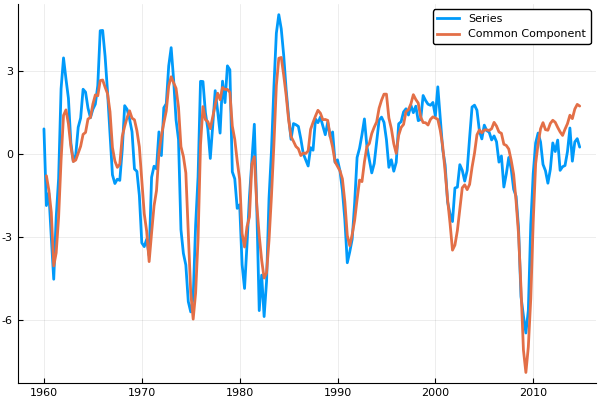

In [55]:
plot(year, [100*y4 100*y4f], lw=2, lab=["Series" "Common Component"])